# **Проект Мастерской Яндекс практикума**

# Введение

В работе рассматриваются данные одного из интернет магазинов, состоящие из 5 датафреймов. На базе этих датафреймов создана модель машинного обучения, которая предсказывает веротяность повторной покупки клиента.
Метрикой для оценки качества модели является ROC-AUC.

# Описание задачи

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи.
<br>Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.
<br>Решение данной задачи может быть применено в следующих областях:
 - оптимизация промо-офферов для тех клиентов, которые покупку не совершили;
 - кластеризация пользователей по интересам;
 - управление пользовательской базой для достижения снижения оттока;
 - тестирование новых продуктов и вариаций продаж.

# Цель проекта

Предсказать вероятность покупки клиентом товара в течение 90 дней.
Цель будет достугнута при создании модели машинного обучения, которая решает задачу классификации.

#План проекта

При выполнении проекта выполняются следующие шаги:
- производится загрузка и обзор данных из файла;
- производится предобработка данных;
- исследовательский анализ данных;
- создаются новые признаки;
- проводится проверка данных на мультиколлинеарность;
- создается модель МО;
- выводится значимость признаков.

Установка необходимых библиотек:

In [13]:
! pip install phik -q
! pip install catboost -q

Загрузка необходимых библиотек и установка значений переменных для работы с графиками в seaborn.

In [15]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import (
                                    StandardScaler,
                                    MinMaxScaler,
                                    OneHotEncoder,
                                    OrdinalEncoder,
                                    LabelEncoder
                                   )
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import phik
from catboost import CatBoostClassifier
plt.rcParams['font.size'] = 10.0
plt.rcParams.update({'axes.titlesize': 'large'})
sns.set_context(
                'notebook',
                rc={
                    'font.size': 10,
                    'axes.titlesize': 10,
                    'xtick.labelsize': 'small',
                    'ytick.labelsize': 'small',
                    'legend.fontsize': 'small',
                    'legend.title_fontsize': 10
                }
            )
RANDOM_STATE = 2025

Общий план проекта:


1.  Проверка зачитанных данных на:
    *   пропуски
    *   явные дубликаты
    *   соответствие типов данных
    *   подготовка к исследовательскому анализу данных.
2.  Исследовательский анализ данных.
Анализирую выбросы и аномалии в данных, заполняю пропуски и исследую данные на неявные дубликаты, работаю с ними.
Цель - понять, как объединить данные для получения итого датасета, по которому будет построена модель МО.
3. Создание финального датасета для обучения модели МL. Из этого сета необходимо сделать отложеную выборку для валидации модели.
4. Создание пайплайна для рассмотрения нескольких моделей МО и выбора наилучшей.
5. Задание со звездой - написать класс.

# Загрузка данных

## Файл apparel-messages
Рассылки, которые были отправлены клиентам из таблицы покупок.
* bulk_campaign_id идентификатор рекламной кампании
* client_id идентификатор пользователя
* message_id идентификатор сообщений
* event тип действия
* channel канал рассылки
* date дата рассылки
* created_at точное время создания сообщения

In [19]:
data_messages = pd.read_csv('C://MyDocs//Data_Scinece_Praktikum//Machine_learning//ML_projects/Skillbox//M2_DS - Clients_for_shop//STD_M2_purchase_in_90_days//filtered_data//apparel-messages.csv', sep=',')
data_messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


Данные успешно зачитаны.

## Файл apparel-purchases
Файл содержит данные о покупках клиентов по дням и по товарам. В каждой записи покупка определенного товара, его цена, количество штук.
<br> В таблице есть списки идентификаторов, к каким категориям относится товар. Часто это вложенные категории (например автотовары-аксессуары-освежители), но также может включать в начале списка маркер распродажи или маркер женщинам/мужчинам.
<br> Нумерация категорий сквозная для всех уровней, то есть 44 на второй позиции списка или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому могут меняться вложенности, например ['4', '28', '44', '1594'] или ['4', '44', '1594'].
* client_id идентификатор пользователя
* quantity количество товаров в заказе
* price цена товара
* category_ids вложенные категории, к которым отнсится товар
* date дата покупки
* message_id идентификатор сообщения из рассылки

In [22]:
data_purchases = pd.read_csv('C://MyDocs//Data_Scinece_Praktikum//Machine_learning//ML_projects/Skillbox//M2_DS - Clients_for_shop//STD_M2_purchase_in_90_days//filtered_data//apparel-purchases.csv', sep=',')
data_purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


Данные успешно зачитаны.

## Файл apparel-target_binary
Данные о том, совершит ли клиент покупку в течение следующих 90 дней:
* client_id - идентификатор пользователя
* target - целевой признак

In [25]:
data_target = pd.read_csv('C://MyDocs//Data_Scinece_Praktikum//Machine_learning//ML_projects/Skillbox//M2_DS - Clients_for_shop//STD_M2_purchase_in_90_days//filtered_data//apparel-target_binary.csv', sep=',')
data_target.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


Данные успешно зачитаны

# Предобработка данных

Начну предобработку данных с таблицы с целевым признаком.

## Анализ таблицы с целевым признаком

In [30]:
data_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


Типы данных соответствуют.

Убеждаюсь, что пропусков нет.

In [33]:
data_target.isna().sum()

client_id    0
target       0
dtype: int64

Проверяю уникальные значения целевого признака, чтобы убедиться в том, что все в порядке.

In [35]:
data_target['target'].unique()

array([0, 1], dtype=int64)

Смотрю количество значений таргета на предмет дисбаланса классов:

In [37]:
data_target['target'].value_counts()

target
0    48888
1      961
Name: count, dtype: int64

Как видно, совершивших покупку клиентов значительно меньше, чем тех, кто покупку не совершил. Следовательно нужно делать стратификацию при формировании обучающей выборки.

Проверка на явные дубликаты

In [40]:
data_target.duplicated().sum()

0

Явных дубликатов нет. Данные готовы к дальнейшему использованию.

## Анализ данных датасета data_messages

In [43]:
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


Преобразю данные даты и времени в соответствующий тип datetime:

In [45]:
data_messages['date'] = pd.to_datetime(data_messages['date'], format='%Y-%m-%d')
data_messages['created_at'] = pd.to_datetime(data_messages['created_at'], format='%Y-%m-%d %H:%M:%S')
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


In [46]:
data_messages.head(5)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


Проверяю данные на пропуски

In [48]:
data_messages.isna().sum()

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

Проверка данных на явные дубликаты

In [50]:
data_messages.duplicated().sum()

48610

В данных обнаружены явные дубликаты. Каждая строчка содержит дату с минутами и секундами, поэтому такая запись уникальна. Следовательно обнаруженные дубликаты подлежат удалению.

In [52]:
data_messages = data_messages.drop_duplicates().reset_index(drop=True)

Проверяю, что явные дубликаты убраны:

In [54]:
data_messages.duplicated().sum()

0

Проверю, все ли client id датафрейма совпадают с данными с таргетом:

## Анализ данных датасета data_purchases

In [57]:
data_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [58]:
data_purchases['date'] = pd.to_datetime(data_purchases['date'], format='%Y-%m-%d')
data_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


In [59]:
data_purchases.head(5)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [60]:
data_purchases['date'].describe()

count                           202208
mean     2023-03-17 02:49:35.739832064
min                2022-05-16 00:00:00
25%                2022-11-12 00:00:00
50%                2023-04-12 00:00:00
75%                2023-07-03 00:00:00
max                2024-02-16 00:00:00
Name: date, dtype: object

Проверяю данные на пропуски.

In [62]:
data_purchases.isna().sum()

client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64

In [63]:
data_purchases.duplicated().sum()

73020

Формально явные дубликаты имеются, однако фактически несколько позиций купленного товара идут отдельными записями и не считаются как явные дубликаты, поэтому будут сохранены.

Определяю количество уникальных client_id

In [66]:
len(data_purchases['client_id'].unique())

49849

Количество уникальных client_id совпадает количеством строк датафрейма data_target. Сделаю проверку на соответствие client_id:

In [68]:
for elm in data_purchases['client_id'].unique():
    if elm not in data_target['client_id'].unique():
        print('Клиент с client_id', elm, 'не найден в data_target')

Отсутствие сообщений подтвердило полное соответствие client_id двух датафреймов.

# Исследовательский анализ данных

## Исследую данные из таблицы data_purchase

In [72]:
data_purchases['price'].describe()

count    202208.000000
mean       1193.301516
std        1342.252664
min           1.000000
25%         352.000000
50%         987.000000
75%        1699.000000
max       85499.000000
Name: price, dtype: float64

Минимальное значение цены 1 евро, максимальное значение цены одной покупки 85499 евро, что весьма значительно, поскольку третий квантиль составляет 1699 евро. Это либо выброс из-за ошибки в данных, либо это очень дорогая брендовая вещь.
<br> Построю гистограмму для визуализации:

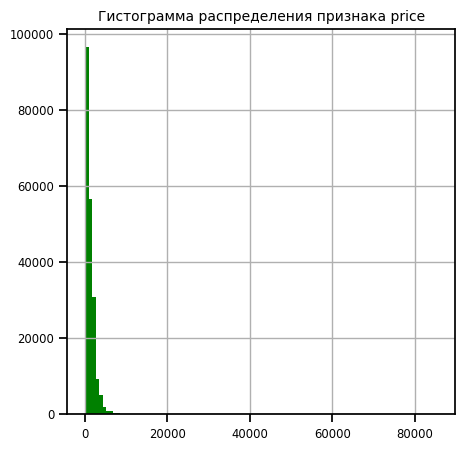

In [74]:
data_purchases['price'].hist(
    bins=100,
    figsize=[5, 5],
    color='green')
plt.title('Гистограмма распределения признака price')
plt.show();

Как видно, большая часть товаров идет по цене до 10000 евро, остальное - брендовые вещи.

Для понимания выведу строку датаферйма с максимальным значением:

In [77]:
cond = data_purchases['price'] == data_purchases['price'].max()
data_purchases[cond]

,client_id,quantity,price,category_ids,date,message_id
186736,1515915625553309277,1,85499.0,"['4', '29', '313', '1574']",2023-12-24,1515915625553309277-14352-6585585d7a711


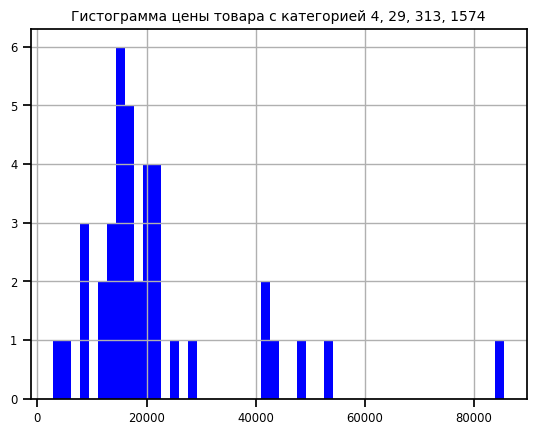

In [78]:
cond = (data_purchases['category_ids'] == "['4', '29', '313', '1574']")
data_purchases[cond].hist(
    'price',
    bins=50,
    color='blue')
plt.title('Гистограмма цены товара с категорией 4, 29, 313, 1574')
plt.show();

Распределение цены на товар имеет значительный диапазон. И все же максимальное значение цены встречается лишь один раз.
<br> Вывожу данные по всем покупкам клиента, сделавшего самую дорогую покупку:

In [80]:
cond = data_purchases['client_id'] == 1515915625553309277
len(data_purchases[cond])

20

In [81]:
data_purchases[cond]

,client_id,quantity,price,category_ids,date,message_id
186733,1515915625553309277,1,24999.0,"['4', '29', '313', '1574']",2023-12-24,1515915625553309277-14352-6585585d7a711
186734,1515915625553309277,1,21962.0,"['4', '29', '313', '1574']",2023-12-24,1515915625553309277-14352-6585585d7a711
186735,1515915625553309277,1,21962.0,"['4', '29', '313', '1574']",2023-12-24,1515915625553309277-14352-6585585d7a711
186736,1515915625553309277,1,85499.0,"['4', '29', '313', '1574']",2023-12-24,1515915625553309277-14352-6585585d7a711
188161,1515915625553309277,1,20999.0,"['4', '29', '312', '1576']",2023-12-26,1515915625553309277-14386-6589563c81fe6
188162,1515915625553309277,1,20999.0,"['4', '29', '312', '1576']",2023-12-26,1515915625553309277-14386-6589563c81fe6
188163,1515915625553309277,1,25499.0,"['4', '29', '312', '1576']",2023-12-26,1515915625553309277-14386-6589563c81fe6
188164,1515915625553309277,1,29499.0,"['4', '29', '312', '1581']",2023-12-26,1515915625553309277-14386-6589563c81fe6
188165,1515915625553309277,1,29999.0,"['4', '29', '312', '1576']",2023-12-26,1515915625553309277-14386-6589563c81fe6
188166,1515915625553309277,1,17849.0,"['4', '29', '312', '1576']",2023-12-26,1515915625553309277-14386-6589563c81fe6


Как следует из таблицы выше покупатель приобрел 4 товара категории ['4', '29', '313', '1574'] в один день по разным ценам, в том числе и по самой высокой. Видимо это супер дорогая брендовая вещь.

In [83]:
data_purchases['quantity'].describe()

count    202208.000000
mean          1.006483
std           0.184384
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          30.000000
Name: quantity, dtype: float64

In [84]:
data_purchases['quantity'].unique()

array([ 1,  2,  3, 10,  4, 25, 20, 13, 30, 15,  6, 18,  8,  9,  5,  7],
      dtype=int64)

Поскольку количество товара встречается более 1 позиции, то введу столбец 'tot_spent'.

In [86]:
data_purchases['tot_spent'] = data_purchases['quantity'] * data_purchases['price']
data_purchases.head()

,client_id,quantity,price,category_ids,date,message_id,tot_spent
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,1999.0
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,2499.0
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,6499.0
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,4999.0
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,4999.0


Выведу количество уникальных category_ids:

In [88]:
len(data_purchases['category_ids'].unique())

933

In [89]:
min_cat_items = 10
max_cat_items = 0
for elm in data_purchases['category_ids'].unique():
    if max_cat_items < elm.count("'") // 2:
        max_cat_items = elm.count("'") // 2
    if min_cat_items > elm.count("'") // 2:
        min_cat_items = elm.count("'") // 2
print(f'Максимальное число подкатегорий в category_ids составляет {max_cat_items}')
print(f'Минимальное число подкатегорий в category_ids составляет {min_cat_items}')

Максимальное число подкатегорий в category_ids составляет 5
Минимальное число подкатегорий в category_ids составляет 0


Как видно есть "пустышки". Максимальное количество вложенных подкатегорий составляет 5. Следовательно размерность категорий разная. В итоге есть смысл выделить только основную категорию.

Посчитаю количество пустых категорий товара:

In [92]:
len(data_purchases[data_purchases['category_ids'] == '[]'])

5579

Количество пустышек выглядит по абсолютной метрике большим. Посмотрю относительное значение:

In [94]:
format(len(data_purchases[data_purchases['category_ids'] == '[]'])/len(data_purchases), '0.2%')

'2.76%'

Значений не много. При группировке данных и выделении основной категории для каждого клиента по моде пустышки должны пропасть.

Исследую столбец с датой:

In [97]:
data_purchases['date'].describe()

count                           202208
mean     2023-03-17 02:49:35.739832064
min                2022-05-16 00:00:00
25%                2022-11-12 00:00:00
50%                2023-04-12 00:00:00
75%                2023-07-03 00:00:00
max                2024-02-16 00:00:00
Name: date, dtype: object

Если принять что выгрузка данных датируется максимальным значением даты, то можно писчитать для каждого клиента разницу дней между его посленей покупкой и этой крайней датой иввести это как признак.

Выделю номер основной категории покупки:

In [100]:
def main_cat(row):
    mcl = row['category_ids'].find("'", 2)
    #print(type(mcl), mcl)
    if mcl > 0:
        m_c = int(row['category_ids'][2:mcl])
    else:
        m_c = 0
    return m_c

In [101]:
data_purchases['primary_cat'] = data_purchases.apply(main_cat, axis=1)
data_purchases.head()

,client_id,quantity,price,category_ids,date,message_id,tot_spent,primary_cat
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,1999.0,4
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,2499.0,4
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,6499.0,4
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,4999.0,4
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,4999.0,4


Проверю как отработала функция

In [103]:
data_purchases['primary_cat'].unique()

array([   4,    2, 5562,    1,    0, 5963,    3, 6060,    5], dtype=int64)

In [104]:
data_purchases['primary_cat'].mode().values[0]

4

### Создаю новые признаки на базе purchases

In [106]:
train_data = data_purchases.pivot_table(index='client_id',
                           values = ['quantity', 'tot_spent', 'primary_cat', 'date'],
                           aggfunc = {'quantity': np.sum,
                                      'tot_spent': np.sum,
                                      'primary_cat': st.mode,
                                      'date':  lambda x: data_purchases['date'].max() - max(x)
                                      }).reset_index()

C:\Users\Вячеслав\AppData\Local\Temp\ipykernel_2528\478020472.py:1: FutureWarning: The provided callable <function sum at 0x0000020C3E074220> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  train_data = data_purchases.pivot_table(index='client_id',


In [107]:
train_data['date'] = train_data['date'].dt.days
train_data['primary_cat'] = train_data['primary_cat'].apply(lambda x: x[0])
train_data = train_data.rename(columns={'date':'days_from_output_date'})
train_data.head()

,client_id,days_from_output_date,primary_cat,quantity,tot_spent
0,1515915625468060902,630,4,7,6993.0
1,1515915625468061003,408,4,7,16235.0
2,1515915625468061099,640,4,1,299.0
3,1515915625468061100,6,4,2,2098.0
4,1515915625468061170,244,4,19,33601.0


In [108]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   client_id              49849 non-null  int64  
 1   days_from_output_date  49849 non-null  int64  
 2   primary_cat            49849 non-null  int64  
 3   quantity               49849 non-null  int64  
 4   tot_spent              49849 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 1.9 MB


## Исследую данные из таблицы data_messages

Количество уникальных client_id составляет:

In [111]:
len(data_messages['client_id'].unique())

53329

Это значение больше, чем в таргете. Следовательно нужно избавиться от лишних client_id.

In [113]:
cond = data_messages['client_id'].isin(data_target['client_id'].unique())
data_messages = data_messages[cond]

Проверяю новое количество уникальных client_id:

In [115]:
len(data_messages['client_id'].unique())

41982

Значений вышло меньше, чем в таргете. Для отсутствующих клиентов придется заполнять признаки "заглушками".

Выведу уникальные значения для категории channel:

In [118]:
data_messages['channel'].unique()

array(['email', 'mobile_push'], dtype=object)

Посчитаю количество сообщений, отправленных по разному каналу отправки сообщений.

In [120]:
data_messages.channel.value_counts()

channel
mobile_push    6088089
email          4825108
Name: count, dtype: int64

В целом по электронной почте было отправлено меньше всего сообщений. Есть смысл ввести признак моды канала для каждого пользователя.

Создаю сводную таблицу с признаками основного вида канала channel, количества event и количества рассылок, сделанных пользователю.

In [123]:
train_messages = data_messages.pivot_table(index = 'client_id',
                          values = ['channel', 'event', 'message_id'],
                          aggfunc = {'channel': pd.Series.mode,
                                     'event': pd.Series.count,
                                     'message_id': pd.Series.nunique
                                     }).reset_index()
train_messages = train_messages.rename(columns={'event': 'total_events', 'message_id': '#_of_message_ids'})
train_messages['channel']= train_messages['channel'].apply(lambda x: str(x))
train_messages.head()

,client_id,channel,total_events,#_of_message_ids
0,1515915625468060902,email,177,127
1,1515915625468061003,email,165,154
2,1515915625468061099,email,276,215
3,1515915625468061100,mobile_push,428,268
4,1515915625468061170,email,293,243


In [124]:
train_messages['channel'].unique()

array(['email', 'mobile_push', "['email' 'mobile_push']"], dtype=object)

In [125]:
train_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41982 entries, 0 to 41981
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         41982 non-null  int64 
 1   channel           41982 non-null  object
 2   total_events      41982 non-null  int64 
 3   #_of_message_ids  41982 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.3+ MB


Вывожу уникальные значения признака event:

In [127]:
data_messages['event'].unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'soft_bounce', 'subscribe', 'complain', 'close'],
      dtype=object)

In [128]:
cond = data_messages['event'] == 'purchase'
data_messages[cond].head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
27,4439,1515915625498693110,1515915625498693110-4439-62834130c8234,purchase,email,2022-05-19,2022-05-19 02:05:20
54,4439,1515915625558950747,1515915625558950747-4439-6283411f3ad55,purchase,email,2022-05-19,2022-05-19 03:15:19
58,4439,1515915625490515072,1515915625490515072-4439-6283411e33838,purchase,email,2022-05-19,2022-05-19 03:19:12
61,4439,1515915625490515072,1515915625490515072-4439-6283411e33838,purchase,email,2022-05-19,2022-05-19 03:25:13
62,4439,1515915625490515072,1515915625490515072-4439-6283411e33838,purchase,email,2022-05-19,2022-05-19 03:27:40


Количество рассылок, которые имели event purchase:

In [130]:
data_messages[data_messages['event'] == 'purchase']['message_id'].nunique()

44493

Количество клиентов, у которых есть event = purchase:

In [132]:
data_messages[data_messages['event'] == 'purchase']['client_id'].nunique()

37485

Создаю таблицу с группировкой по клиентам, для которых были события purchase:

In [134]:
pt_data_mess_pe = data_messages[data_messages['event'] == 'purchase'].pivot_table(index = 'client_id',
                                                                 values = ['event'],
                                                                aggfunc = {'event': pd.Series.count
                                                                          }).reset_index()
pt_data_mess_pe = pt_data_mess_pe.rename(columns={'event': 'purchase_events_tot'})

Объединяю со сводной табицей с признаками из датафрейма по сообщениям:

In [136]:
train_messages = train_messages.merge(pt_data_mess_pe, how='left', on='client_id')
train_messages.tail()

,client_id,channel,total_events,#_of_message_ids,purchase_events_tot
41977,1515915626010079153,mobile_push,3,1,1.0
41978,1515915626010152263,mobile_push,5,1,2.0
41979,1515915626010183608,mobile_push,4,2,NaN
41980,1515915626010221592,mobile_push,6,2,NaN
41981,1515915626010261344,mobile_push,3,1,NaN


Заполняю пропуски в столбце purchase_events_tot нулями в предположении, что покупок не было:

In [138]:
train_messages['purchase_events_tot'] = train_messages['purchase_events_tot'].fillna(0).astype('int32')
train_messages.head()

,client_id,channel,total_events,#_of_message_ids,purchase_events_tot
0,1515915625468060902,email,177,127,5
1,1515915625468061003,email,165,154,1
2,1515915625468061099,email,276,215,0
3,1515915625468061100,mobile_push,428,268,1
4,1515915625468061170,email,293,243,3


Значение purchase по сути является целевым признаком. Есть смысл ввести признак числа часов между временем рассылки и временем покупки. Для тех пользователей, которые вообще покупки не сделали можно приравнять его к очень болльшому значению.

Собираю рассылки, которые закончились покупками в отдельный датафрейм.

In [141]:
data_mess_w_pur = data_messages[data_messages['message_id'].isin(data_messages[data_messages['event'] == 'purchase']['message_id'].unique())].reset_index(drop=True)

In [142]:
data_mess_w_pur.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625498693110,1515915625498693110-4439-62834130c8234,click,email,2022-05-19,2022-05-19 01:50:17
1,4439,1515915625490518497,1515915625490518497-4439-62834144139ae,open,email,2022-05-19,2022-05-19 01:57:06
2,4439,1515915625490518497,1515915625490518497-4439-62834144139ae,click,email,2022-05-19,2022-05-19 01:58:19
3,4439,1515915625490515072,1515915625490515072-4439-6283411e33838,open,email,2022-05-19,2022-05-19 02:03:22
4,4439,1515915625498693110,1515915625498693110-4439-62834130c8234,purchase,email,2022-05-19,2022-05-19 02:05:20


Создам сводную таблицу с вычислением времени между первым и последним events для каждого message_id в минутах:

In [144]:
data_mess_time_delta = data_mess_w_pur.pivot_table(index = 'message_id',
                                                   values = ['created_at', 'client_id'],
                                                   aggfunc = {'created_at': lambda x: (max(x) - min(x)),
                                                              'client_id': min
                                                             }).reset_index().drop(['message_id'], axis=1)
data_mess_time_delta['created_at'] = data_mess_time_delta['created_at'].dt.total_seconds().div(60).astype(int)
data_mess_time_delta.head()

C:\Users\Вячеслав\AppData\Local\Temp\ipykernel_2528\2566946430.py:1: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  data_mess_time_delta = data_mess_w_pur.pivot_table(index = 'message_id',


,client_id,created_at
0,1515915625468060902,398
1,1515915625468061003,441
2,1515915625468061100,1916
3,1515915625468061170,5759
4,1515915625468061170,130


Теперь из полученной таблицы сделаю сводную таблицу по клиентам с минимальным временем между крайними events рассылки:

In [146]:
data_mess_time_delta = data_mess_time_delta.pivot_table(index='client_id',
                                 values='created_at',
                                 aggfunc=min).reset_index()
data_mess_time_delta = data_mess_time_delta.rename(columns={'created_at': 'min_time_delta_4_event'})
data_mess_time_delta.head()

C:\Users\Вячеслав\AppData\Local\Temp\ipykernel_2528\1043376489.py:1: FutureWarning: The provided callable <built-in function min> is currently using DataFrameGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  data_mess_time_delta = data_mess_time_delta.pivot_table(index='client_id',


,client_id,min_time_delta_4_event
0,1515915625468060902,398
1,1515915625468061003,441
2,1515915625468061100,1916
3,1515915625468061170,130
4,1515915625468061514,1408


Выведу максимальное значение признака:

In [148]:
data_mess_time_delta['min_time_delta_4_event'].describe()

count     37485.000000
mean       3752.382553
std       21737.615368
min           0.000000
25%         148.000000
50%        1046.000000
75%        2266.000000
max      736280.000000
Name: min_time_delta_4_event, dtype: float64

Максмальным временем заполню данные для клиентов, по которым нет рассылок с event значением purchase

In [150]:
train_messages = train_messages.merge(data_mess_time_delta, how='left', on='client_id')
train_messages.head()

,client_id,channel,total_events,#_of_message_ids,purchase_events_tot,min_time_delta_4_event
0,1515915625468060902,email,177,127,5,398.0
1,1515915625468061003,email,165,154,1,441.0
2,1515915625468061099,email,276,215,0,NaN
3,1515915625468061100,mobile_push,428,268,1,1916.0
4,1515915625468061170,email,293,243,3,130.0


In [151]:
train_messages['min_time_delta_4_event'] = train_messages['min_time_delta_4_event'].fillna(data_mess_time_delta['min_time_delta_4_event'].max()*10)
train_messages.head()

,client_id,channel,total_events,#_of_message_ids,purchase_events_tot,min_time_delta_4_event
0,1515915625468060902,email,177,127,5,398.0
1,1515915625468061003,email,165,154,1,441.0
2,1515915625468061099,email,276,215,0,7362800.0
3,1515915625468061100,mobile_push,428,268,1,1916.0
4,1515915625468061170,email,293,243,3,130.0


# Создание финального датафрейма для модели МО

Объединяю все признаки в одну таблицу и проведу заполнение отсутствующих данных.

In [154]:
final_data = data_target.merge(train_messages, how='left', on='client_id').merge(train_data, how='left', on='client_id')
final_data.head()

,client_id,target,channel,total_events,#_of_message_ids,purchase_events_tot,min_time_delta_4_event,days_from_output_date,primary_cat,quantity,tot_spent
0,1515915625468060902,0,email,177.0,127.0,5.0,398.0,630,4,7,6993.0
1,1515915625468061003,1,email,165.0,154.0,1.0,441.0,408,4,7,16235.0
2,1515915625468061099,0,email,276.0,215.0,0.0,7362800.0,640,4,1,299.0
3,1515915625468061100,0,mobile_push,428.0,268.0,1.0,1916.0,6,4,2,2098.0
4,1515915625468061170,0,email,293.0,243.0,3.0,130.0,244,4,19,33601.0


In [155]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   client_id               49849 non-null  int64  
 1   target                  49849 non-null  int64  
 2   channel                 41982 non-null  object 
 3   total_events            41982 non-null  float64
 4   #_of_message_ids        41982 non-null  float64
 5   purchase_events_tot     41982 non-null  float64
 6   min_time_delta_4_event  41982 non-null  float64
 7   days_from_output_date   49849 non-null  int64  
 8   primary_cat             49849 non-null  int64  
 9   quantity                49849 non-null  int64  
 10  tot_spent               49849 non-null  float64
dtypes: float64(5), int64(5), object(1)
memory usage: 4.2+ MB


Заполню пропуски в столбцах модой:

In [157]:
col_na = ['total_events', '#_of_message_ids', 'purchase_events_tot', 'min_time_delta_4_event']
for col in col_na:
    val = final_data[col].mode()[0]
    final_data[col] = final_data[col].fillna(val)
final_data['channel'] = final_data['channel'].fillna('mobile_push')
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   client_id               49849 non-null  int64  
 1   target                  49849 non-null  int64  
 2   channel                 49849 non-null  object 
 3   total_events            49849 non-null  float64
 4   #_of_message_ids        49849 non-null  float64
 5   purchase_events_tot     49849 non-null  float64
 6   min_time_delta_4_event  49849 non-null  float64
 7   days_from_output_date   49849 non-null  int64  
 8   primary_cat             49849 non-null  int64  
 9   quantity                49849 non-null  int64  
 10  tot_spent               49849 non-null  float64
dtypes: float64(5), int64(5), object(1)
memory usage: 4.2+ MB


In [158]:
final_data['channel'].unique()

array(['email', 'mobile_push', "['email' 'mobile_push']"], dtype=object)

Построю матрицу корреляции:

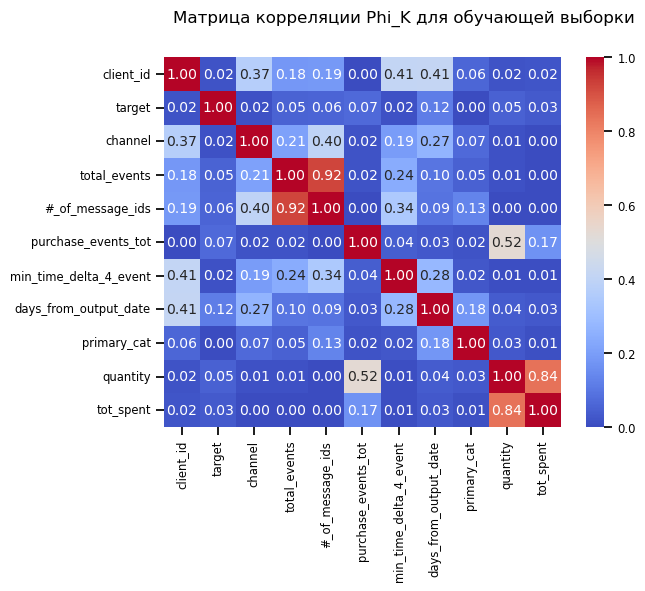

<Figure size 1500x1000 with 0 Axes>

In [160]:
plt.suptitle('Матрица корреляции Phi_K для обучающей выборки')
sns.heatmap(
    final_data.phik_matrix(
      interval_cols=['client_id', 'target', 'total_events', '#_of_message_ids', 'purchase_events_tot', 'min_time_delta_4_event', 'days_from_output_date', 'primary_cat', 'quantity', 'tot_spent']
    ), annot=True, fmt='.2f', cmap='coolwarm'
);
plt.figure(figsize=(15, 10))
plt.show();

Из графика видно, что только признак days_from_output_date имеет наибоьший коэффициент корреляции, но его величниа составляет 0.12, что очень мало.
<br>Видимо необходимо пересмотреть и добавить новые признаки.

Формирую обучающую и валидационную выборки:

In [163]:
X = final_data.drop(['target', 'client_id'], axis=1)
y = final_data['target']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.25,
    random_state=RANDOM_STATE,
    stratify=y
)

Создаю пайплайны для подготовки данных:

In [165]:
ohe_col = ['primary_cat']
ohe_pipe = Pipeline(
    [
      (
       'ohe',
       OneHotEncoder(drop='first',
                     handle_unknown='ignore')#,
                     #sparse=False)
      )
    ]
)

In [166]:
ord_col = ['channel']

In [167]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [168]:
num_col = ['total_events', '#_of_message_ids', 'purchase_events_tot', 'min_time_delta_4_event', 'days_from_output_date', 'quantity', 'tot_spent']

In [169]:
data_preproc = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_col),
        ('ord', ord_pipe, ord_col),
        ('num', StandardScaler(), num_col),
    ],
    remainder='passthrough'
)

Ввожу модели с их гиперпараметрами для прербора:

# Создание моделей машинного обучения

In [172]:
param_distr = [
    {
        'models': [LogisticRegression()],
        'models__penalty': ['l1', 'l2', 'elasticnet'],
        'preproc__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [DecisionTreeClassifier()],
        'models__max_depth': [5, 10, 15, 20]
    },
    {
        'models': [CatBoostClassifier(loss_function="Logloss", verbose=False)],
        'models__max_depth': [10, 15, 20], # максимальная глубина дерева
        'models__n_estimators': [50, 75, 100] # число деревьев в бустинге
    }

]

In [173]:
pipe_final = Pipeline(
    [
        ('preproc', data_preproc),
        ('models', LogisticRegression())
    ]
)

In [174]:
rand_srch = RandomizedSearchCV(
    pipe_final,
    param_distr,
    cv = 5,
    scoring='roc_auc',
    random_state = RANDOM_STATE,
    n_jobs=-1
)

In [175]:
rand_srch.fit(X_train, y_train)

C:\Anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Anaconda\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Anaconda\Lib\site-packages\sklearn\pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "C:\Anacond

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preproc',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['primary_cat']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ord',
                                                                                                OrdinalEncoder(handle_unknown='u...
                   param_distributions=[{'models': [LogisticRegression()],
                                         'models__penalty': ['l1', 'l2',
                                                             'elasticnet'],
                                         'preproc__num': [StandardScaler(),
                                                          MinMaxScaler()]},
                                        {'models': [DecisionTreeClassifier()],
                                         'models__max_depth': [5, 10, 15, 20]},
                                        {'models': [<catboost.core.CatBoostClassifier object at 0x0000020C00BBA6C0>],
                                         'models__max_depth': [10, 15, 20],
                                         'models__n_estimators': [50, 75,
                                                                  100]}],
                   random_state=2025, scoring='roc_auc')

In [176]:
result = pd.DataFrame(rand_srch.cv_results_)
result[['rank_test_score', 'param_models', 'mean_test_score','params', 'mean_score_time']].sort_values(['rank_test_score', 'mean_score_time']).head(20)

,rank_test_score,param_models,mean_test_score,params,mean_score_time
1,1,LogisticRegression(),0.708702,"{'preproc__num': StandardScaler(), 'models__pe...",0.036239
8,2,<catboost.core.CatBoostClassifier object at 0x...,0.693091,"{'models__n_estimators': 75, 'models__max_dept...",0.575514
7,3,<catboost.core.CatBoostClassifier object at 0x...,0.690962,"{'models__n_estimators': 50, 'models__max_dept...",0.665444
4,4,<catboost.core.CatBoostClassifier object at 0x...,0.667335,"{'models__n_estimators': 50, 'models__max_dept...",1.092789
0,5,<catboost.core.CatBoostClassifier object at 0x...,0.658048,"{'models__n_estimators': 100, 'models__max_dep...",0.832013
3,6,<catboost.core.CatBoostClassifier object at 0x...,0.658006,"{'models__n_estimators': 75, 'models__max_dept...",1.899425
6,7,DecisionTreeClassifier(),0.607713,"{'models__max_depth': 10, 'models': DecisionTr...",0.109353
2,8,DecisionTreeClassifier(),0.536565,"{'models__max_depth': 20, 'models': DecisionTr...",0.040087
5,9,LogisticRegression(),NaN,"{'preproc__num': StandardScaler(), 'models__pe...",0.000000
9,9,LogisticRegression(),NaN,"{'preproc__num': MinMaxScaler(), 'models__pena...",0.000000


In [177]:
y_pred = rand_srch.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print(f'Метрика ROC AUC для валидационной выборки составляет: {roc_auc:0.4f}')

Метрика ROC AUC для валидационной выборки составляет: 0.5000


C:\Anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Вывожу лучшую модель и график важности признаков для неё:

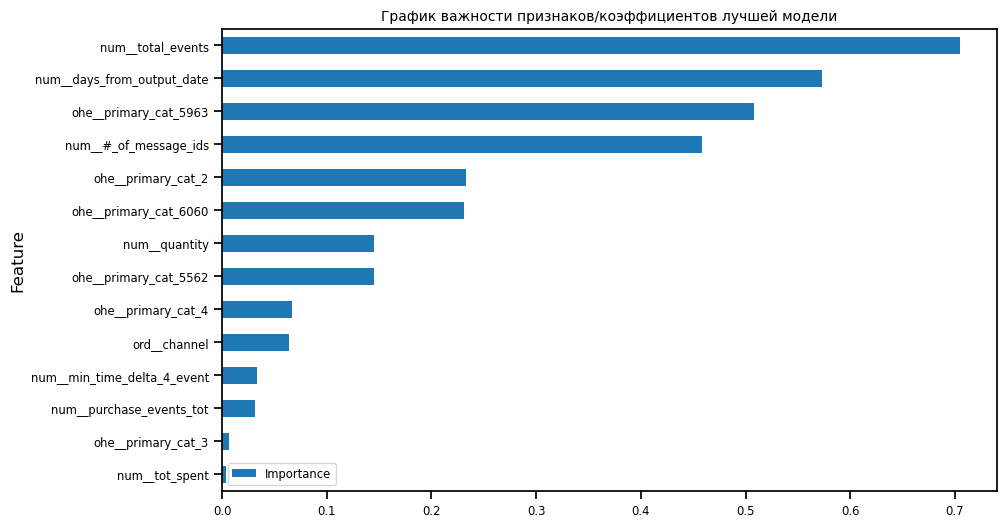

In [179]:
if str(rand_srch.best_estimator_[1]) == 'LogisticRegression()':
    coeff = rand_srch.best_estimator_[1].coef_
else:
    coeff = rand_srch.best_estimator_[1].feature_importances_
train_features = rand_srch.best_estimator_[0]
features = train_features.get_feature_names_out()
feature_importance = pd.DataFrame(
    {
        'Feature': features,
        'Importance': abs(coeff[0])
    }
)
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(
    x='Feature',
    y='Importance',
    kind='barh',
    title='График важности признаков/коэффициентов лучшей модели',
    figsize=(10, 6)
    );

Судя по величине коэффициентов высокий вклад значимости признаков у total_events (общее число событий с рассылкой) и days_from_output_date (число дней между датой выгрузки и датой последней покупки клиента).

# Выводы

На основе представленных датафреймов были сгенерированы признаки и на их основе составлен датасет, который использовался для создания нескольких моделей машинного обучения. 
<br>Далее был осуществлен подбор моделей и гиперпараметров для выбора наилучшей модели. В результате лучшей моделью стала модель логистической регрессии. Однако получено низкое значение целевой метрики ROC AUC равной 0.5 на валидационной выборке. Это связано с недостаточностью признаков, которые должны иметь более высоки коэффициент корреляции с target.

In [183]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [275]:
#! pip install session-info
#import session_info
#session_info.show()

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8072 sha256=47c0de60da109f5091a8d72ea3ce0b932e30b8f07f37c01655fcf579044211e0
  Stored in directory: c:\users\вячеслав\appdata\local\pip\cache\wheels\23\da\7c\868424f4a5845ab58cd8686e0eb405e9e1e2d4152bf702c39d
Successfully built session-info
